In [1]:
import torch
import os

# Get the current path of the notebook
notebook_path = os.getcwd()

# Construct the path to the directory containing 'fit'
parent_path = os.path.join(notebook_path, '..')
os.chdir(parent_path)
import sys
# Add this parent directory to the system path
sys.path.insert(0, parent_path)
from fit.fit_pnf import PNF as PNFModel
from fit.fit_nf import NF as NFModel
from fit.fit_tnf import TNF as TNFModel
from fit.fit_tf import TF as TFModel
import pytorch_lightning as pl
import torch
from utils.dataloader_jetnet import PointCloudDataloader
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from utils.helpers import get_hists, mass
from utils.dataloader_jetnet import PointCloudDataloader
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator, FuncFormatter


/gpfs/dust/maxwell/user/kaechben/.conda/envs/mdma-cfm/lib/python3.11/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/gpfs/dust/maxwell/user/kaechben/.conda/envs/mdma-cfm/lib/python3.11/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/late

/gpfs/dust/maxwell/user/kaechben/.conda/envs/mdma-cfm/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


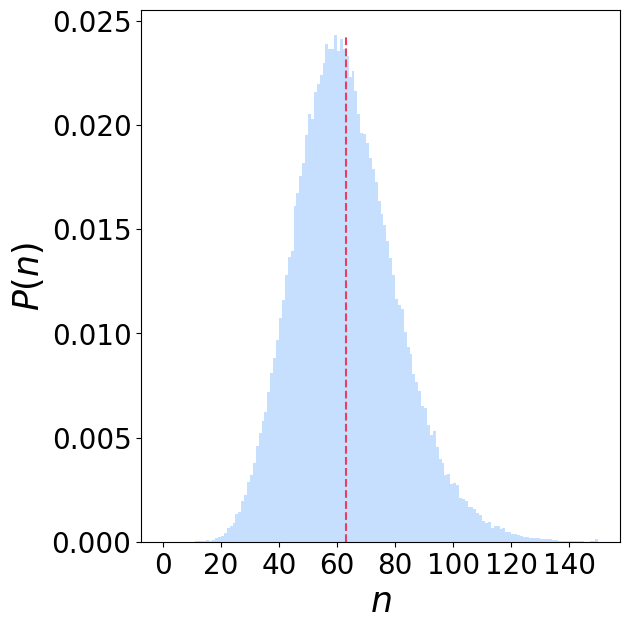

In [2]:
from jetnet.evaluation import w1m
def create_mask(n, size=30):
    # Ensure n is a 1D tensor
    n = n.flatten()

    # Create a range tensor [0, 1, 2, ..., size-1]
    range_tensor = torch.arange(size).unsqueeze(0)

    # Compare range_tensor with n to create the mask
    mask = range_tensor >= n.unsqueeze(1)

    return mask
def fit_kde(n,m,n_max=30):

    from sklearn.neighbors import KernelDensity
    kde=KernelDensity(bandwidth="scott").fit(n.unsqueeze(1).numpy())
    nhat=kde.sample(100000)
    nhat=nhat[nhat<n_max+1]
    mass_distributions = {int(i):m[n==i] for i in n.unique()}
    mass_kdes = {int(i):KernelDensity(bandwidth=1e-3).fit(mass_distributions[i].unsqueeze(1).numpy()) for i in mass_distributions.keys()}


    return kde,mass_kdes
def sample_kde(n,n_kde,m_kde=False):
    #fit kde
    nhat=n_kde.sample(n)
    np.random.shuffle(nhat)
    if m_kde:
        nhat_hist,bins=np.histogram(nhat+0.01,bins=np.arange(0,31),density=False)
        nhat_hist,bins=torch.tensor(nhat_hist),torch.tensor(bins)
        nhat_hist,bins=nhat_hist[nhat_hist>0],bins[1:][nhat_hist>0]

        n_dict={int(i):j for i,j in zip(bins,nhat_hist)}
        ms=[torch.from_numpy(m_kde[int(i)].sample(n_dict[int(i)])) for i in bins]
        mhat=torch.cat(ms).numpy()
        np.random.shuffle(mhat)

        return torch.from_numpy(nhat),torch.from_numpy(mhat)
    else:
        return nhat


from utils.dataloader_jetnet import PointCloudDataloader
from my_cmaps import cmap
FONTSIZE=20
data_module=PointCloudDataloader("t",3,150,1024,False,)
data_module.setup("train")
data=torch.cat((data_module.train_dataloader().dataset,data_module.test_dataloader().dataset),dim=0)
# m=mass(data_module.scaler.inverse_transform(data[:,:,:3].cuda())).cpu()
n=(~data[:,:,-1].bool()).float().sum(1).cpu()


plt.figure(figsize=(6.4,6.4))
norm,_,_=plt.hist(n,bins=np.arange(0,151),density=True,alpha=0.3)
plt.xlabel(r"$n$",fontsize=FONTSIZE+5)
plt.ylabel(r"$P(n)$",fontsize=FONTSIZE+5)
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.vlines(n.mean(),0,max(norm),linestyles="--",color="#EC3D5D")
plt.tight_layout()
plt.savefig("plots/n_dist150.png")
# n_kde,m_kde=fit_kde(n,m)
# n,m=sample_kde(len(data),n_kde,m_kde)
# Trainer setup and model validation



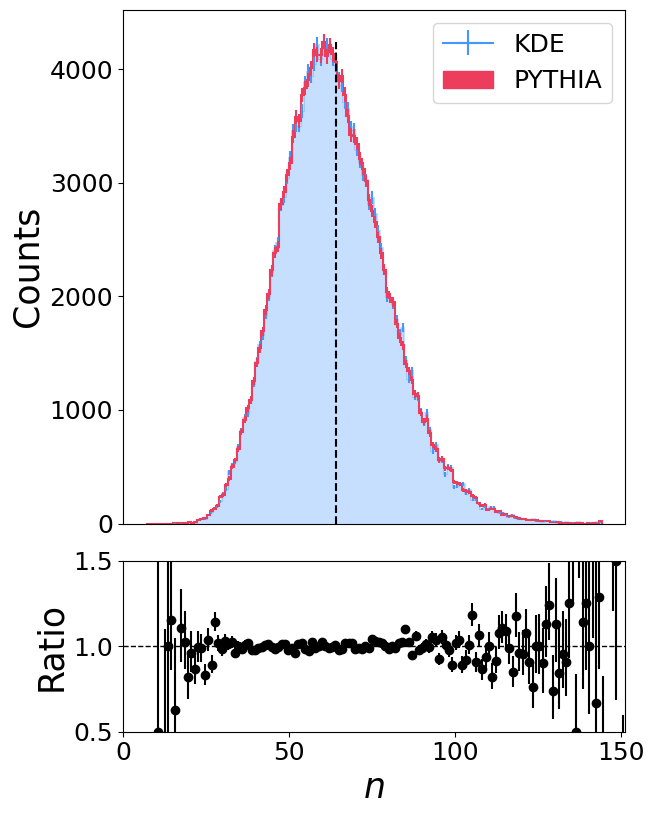

In [4]:
import hist
plt.close()
fig,ax=plt.subplots(2,1,figsize=(6.4,8),height_ratios=[3,1])
nhat=data_module.n_kde.sample(len(n))
h_real=hist.Hist(hist.axis.Regular(150,0,151)).fill(n.reshape(-1).numpy())

h_fake=hist.Hist(hist.axis.Regular(150,0,151)).fill(nhat.reshape(-1))
h_fake.plot_ratio(h_real,ax_dict={"main_ax": ax[0], "ratio_ax": ax[1]},
    rp_ylabel="Ratio",
    bar_="blue",
    rp_num_label="KDE",
    rp_denom_label="PYTHIA",
    rp_uncert_draw_type="line"
)
ax[0].tick_params(axis='x', which='both', length=0, labelbottom=False)
font = { "size": 18}#"family": "normal",
mpl.rc("font", **font)
ax[0].patches[0].set_fill(True)
# plt.suptitle("Agreement between Ground Truth and Generated Data", fontsize=28, fontweight="bold")
plt.tight_layout(pad=0.3)
ax[0].patches[1].set_fc(sns.color_palette()[1])
ax[0].patches[0].set_alpha(0.3)

ax[1].set_xlabel(r"$n$", fontsize=FONTSIZE+5)
ax[0].set_ylabel("Counts", fontsize=FONTSIZE+5)
ax[1].set_ylabel("Ratio", fontsize=FONTSIZE+5)
ax[0].legend(loc="best", fontsize=FONTSIZE)
handles, labels = ax[0].get_legend_handles_labels()
handles[1] = mpatches.Patch(color=sns.color_palette()[1], label="The red data")
ax[0].legend(handles, labels)
ax[0].vlines(n.mean(),0,np.unique(n,return_counts=1)[1].max(),linestyles="--",color="black")
# ax[0].xticks(fontsize=FONTSIZE)
# ax[1].yticks(fontsize=FONTSIZE)
# ax[1].xticks(fontsize=FONTSIZE)
# ax[0].yticks(fontsize=FONTSIZE)

ax[1].set_ylim(0.5, 1.5)
ax[0].set_xlabel("")
plt.savefig("plots/n_kde150.png")
plt.show()

{'batch_size': 256, 'ckpt_flow': './ckpts/t_nflow.ckpt', 'ckpt': '', 'norm': True, 'num_layers': 4, 'fast': False, 'dropout': 0, 'dataset': 'jet', 'heads_gen': 16, 'heads': 16, 'num_heads': 16, 'hidden_gen': 256, 'hidden': 256, 'l_dim_gen': 16, 'l_dim': 16, 'lr': 0.0001, 'mass_loss': False, 'max_epochs': 2000, 'max': False, 'mean_field_loss': True, 'model': 'TNF', 'gan': 'lsgan', 'gp': False, 'freq': 1, 'name': 'jet_tnf', 'num_layers_gen': 4, 'opt': 'AdamW', 'weightdecay': 0.01, 'parton': 't', 'n_dim': 3, 'n_part': 30, 'N': 1, 'noise': False, 'cond_dim': 0, 'bins': [100, 100, 100, 100], 'pretrain': False, 'sampler': True, 'start_swa': False, 'amp': False, 'coupling_layers': 10, 'coupling_hidden': 256, 'spline': True, 'network_layers': 6, 'hidden_features': 256, 'tail_bound': 6, 'num_bins': 8, 'batchnorm': False, 'context_features': 0, 'num_batches': 486}


(array([  4.,   8.,  14.,  40.,  53.,  75., 102., 166., 230., 326., 467.,
        469., 396., 386., 479., 456., 540., 652., 733., 865., 878., 923.,
        796., 530., 261.,  99.,  31.,  13.,   7.,   1.]),
 array([0.01650176, 0.02275386, 0.02900597, 0.03525808, 0.04151018,
        0.04776229, 0.05401439, 0.0602665 , 0.0665186 , 0.07277071,
        0.07902281, 0.08527492, 0.09152702, 0.09777913, 0.10403124,
        0.11028334, 0.11653545, 0.12278755, 0.12903966, 0.13529176,
        0.14154387, 0.14779597, 0.15404808, 0.16030018, 0.16655229,
        0.17280439, 0.1790565 , 0.18530861, 0.19156071, 0.19781282,
        0.20406492]),
 <BarContainer object of 30 artists>)

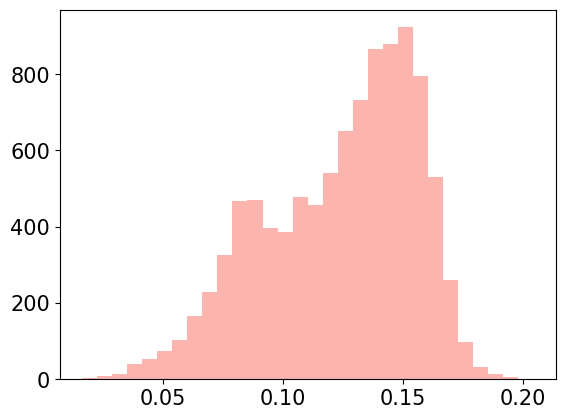

In [13]:
ckpt = torch.load("ckpts/tnf_slow.ckpt")
config = ckpt["hyper_parameters"]
print(config)
data_module = PointCloudDataloader(**config)
data_module.setup("train")



flow = TNFModel(**config).load_from_checkpoint("ckpts/tnf_slow.ckpt",**config)
flow.scaler=data_module.scaler.to("cuda")
flow.scaled_mins=torch.from_numpy(data_module.mins).cuda()
flow.scaled_maxs=torch.from_numpy(data_module.maxs).cuda()
flow.load_datamodule(data_module)
flow.cuda()
data=data_module.train_dataloader().dataset[:10000]
data,mask=data[:,:,:3],data[:,:,-1].bool()
with torch.no_grad():
    data,_=flow.sampleandscale(data.cuda(),mask=mask.cuda(),cond=None,scale=True)
    m=mass(data)
plt.hist(m.cpu().numpy(),bins=30)

In [8]:
with torch.no_grad():
    ckpt=torch.load("./ckpts/t_nflow.ckpt")
ckpt["hyper_parameters"]


{'batch_size': 128,
 'ckpt': False,
 'dropout': 0,
 'dataset': 'jet',
 'hidden_gen': 48,
 'hidden': 64,
 'l_dim_gen': 16,
 'l_dim': 16,
 'lr': 0.0001,
 'mass_loss': False,
 'max_epochs': 2000,
 'max': False,
 'mean_field_loss': True,
 'model': 'NF',
 'name': 'jet_nf',
 'num_layers': 7,
 'opt': 'Adam',
 'weightdecay': 0.0,
 'parton': 't',
 'n_dim': 3,
 'n_part': 30,
 'N': 1,
 'cond_dim': 1,
 'bins': [100, 100, 100, 100],
 'pretrain': False,
 'sampler': True,
 'start_swa': False,
 'amp': False,
 'coupling_layers': 7,
 'coupling_hidden': 128,
 'spline': True,
 'network_layers': 4,
 'hidden_features': 128,
 'tail_bound': 5,
 'num_bins': 8,
 'batchnorm': True,
 'context_features': 0}

In [1]:
import pandas as pd
import numpy as np
import ast
from numpy import array
import re
# Convert string representation of lists back to lists
def convert_str_to_tuple(s):
    # Extract lists from the string using regex
    s=s.replace("\n ","")
    lists = re.findall(r'\[.*?\]', s)
    arrays = [np.array(ast.literal_eval(l)) for l in lists]
    return tuple(arrays)
results=pd.read_csv("bravobenno.csv")
def weighted_mean(x):
        x,w=np.array(x[0]),np.array(x[1])
        weights=1/w**2
        return np.sum(x*weights)/np.sum(weights)
def weighted_std(x):
    w=(1/np.array(x[1]))**2
    sigma=np.sqrt(1/np.sum(w))
    return sigma

def format_mean_sd(mean, sd):
    """round mean and standard deviation to most significant digit of sd and apply latex formatting"""
    decimals = -int(np.floor(np.log10(sd)))
    decimals -= int((sd * 10 ** decimals) >= 9.5)

    if decimals < 0:
        ten_to = 10 ** (-decimals)
        if mean > ten_to:
            mean = ten_to * (mean // ten_to)
        else:
            mean_ten_to = 10 ** np.floor(np.log10(mean))
            mean = mean_ten_to * (mean // mean_ten_to)
        sd = ten_to * (sd // ten_to)
        decimals = 0

    if mean >= 1e3 and sd >= 1e3:
        mean = np.round(mean * 1e-3)
        sd = np.round(sd * 1e-3)
        return f"${mean:.{decimals}f}$k $\\pm {sd:.{decimals}f}$k"
    else:
        return f"${mean:.{decimals}f} \\pm {sd:.{decimals}f}$"
df=results
df["pmm"]=df["w1m"].apply(ast.literal_eval).apply(lambda x:x).apply(weighted_std)
df["w1m"]=df["w1m"].apply(ast.literal_eval).apply(lambda x:x).apply(weighted_mean)
df["pmp"]=df["w1p"].apply(convert_str_to_tuple).apply(lambda x:x).apply(weighted_std)
df["w1p"]=df["w1p"].apply(convert_str_to_tuple).apply(lambda x:x).apply(weighted_mean)
df["pme"]=df["w1efp"].apply(convert_str_to_tuple).apply(lambda x:x).apply(weighted_std)
df["w1efp"]=df["w1efp"].apply(convert_str_to_tuple).apply(lambda x:x).apply(weighted_mean)

df["fpd_std"]=df["fpd"].apply(ast.literal_eval).apply(lambda x:x[1]).apply(np.mean)
df["fpd"]=df["fpd"].apply(ast.literal_eval).apply(lambda x:x[0]).apply(np.mean)
df["kpd_std"]=df["kpd"].apply(ast.literal_eval).apply(lambda x:x[1]).apply(np.mean)
df["kpd"]=df["kpd"].apply(ast.literal_eval).apply(lambda x:x[0]).apply(np.mean)

cols=["name","w1m","w1efp","w1m","pmm","pme","pmp","cov","mmd","fpd","kpd","time","parameters"]
replace_dict={"MPGAN":"MPGAN","t_cpflow":"PF","t_ipflow":"IPF","t_apflow":"APF","t_nflow":"NF","t_ccnflow":"NF(cc)","t_cnflow":"NF(c)","t_tnflow":"TNF","IN":"IN"}
df.loc[:,"model"]=df["model"].apply(lambda x:replace_dict[x])
df=df.set_index("model",drop=True)
df.loc[:,"w1m"]*=1000
df.loc[:,"w1p"]*=1000
df["w1p"]=df["w1p"]
df.loc[:,"w1efp"]*=100000
df["w1efp"]=df["w1efp"]
df.loc[:,"pmm"]*=1000
df.loc[:,"pmp"]*=1000
df.loc[:,"pme"]*=100000
df.loc[:,"fpd"]*=10000
df.loc[:,"fpd_std"]*=10000
df.loc[:,"kpd"]*=10000

df.loc[:,"kpd_std"]*=10000
df.loc[:,"w1m"]=df.apply(lambda x:format_mean_sd(float(x["w1m"]),float(x["pmm"])),axis=1)
df.loc[:,"w1p"]=df.apply(lambda x:format_mean_sd(float(x["w1p"]),float(x["pmp"])),axis=1)
df.loc[:,"w1efp"]=df.apply(lambda x:format_mean_sd(float(x["w1efp"]),float(x["pme"])),axis=1)
df.loc[:,"kpd"]=df.apply(lambda x:format_mean_sd(float(x["kpd"]),float(x["kpd_std"])),axis=1)
df.loc[:,"fpd"]=df.apply(lambda x:format_mean_sd(float(x["fpd"]),float(x["fpd_std"])),axis=1)
df.loc[:,"time"]*=1e6
df.loc[:,"time"]=np.round(df["time"],decimals=1)
order=["PF","IPF","APF","NF","NF(c)","NF(cc)","TNF","MPGAN","IN"]
df=df.loc[order,:]
print(df)
# def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)
# print (count_parameters(model.gen_net))
tex=""
for p in ["t"]:
    temp=df
    for col in df.columns:
        if col not in ["w1m","w1p","w1efp","fpd","kpd","time"]:
            continue
        temp_index=temp[col].astype(str).str.replace("$","").str.replace("k","").str.split("\\").str[0].astype(float)
        mins=temp_index==temp_index.drop("IN").min()
        temp.loc[mins,col]="$\mathbf{"+temp.loc[mins,col].astype(str).str.replace("$","")+"}$"
    temp=temp.reset_index()[["model","w1m","w1p","w1efp","kpd","fpd","time"]]
    temp.columns=["model","$W_1^M (\times 10^{3})$","$W_1^P (\times 10^{3})$","$W_1^{EFP}(\times 10^{5})$","$KPD(\times 10^{4})$","$FPD$","Time $\mu s$"]
    text=temp.to_latex(index=False,escape=False)
    parton="Gluon" if p=="g" else "Light Quark" if p=="q" else "Top Quark"
    tex+="\multirow{9}{*}{"+parton+"} & "+text.split("FPD")[1].split("\\bottomrule")[0].replace("\\\\","\\\\&").replace("\\midrule","").replace("  ","")[:-2]+"\cline{1-8}"
    tex+="\n"
print(tex)


FileNotFoundError: [Errno 2] No such file or directory: 'bravobenno.csv'

In [17]:
results["w1efp"][0]

'(array([0.00025178, 0.00022063, 0.00026026, 0.00043311, 0.00019063]), array([6.04386555e-07, 1.94986961e-06, 2.46654965e-06, 1.54915805e-06,\n       1.93143100e-06]))'